# NEURAL NWTWORKS

神经网络能使用torch.nn包来构建。

现在我们已经了解了autograd，nn依赖于autograd用于定义模型和对他们求导。一个nn.Module包括layers和一个返回output的forward函数。

举例，这是最典型的神经网络——LeNet，用于手写数字识别。

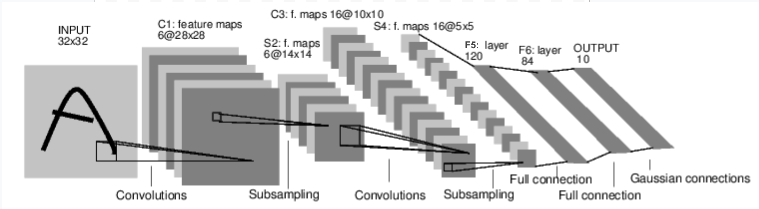

这是一个简单的前馈神经网络（feed-forward）。它接受一个输入，然后将它送入下一层，直到输出output。

一个典型的神经网络包括以下几个训练过程：

1. 定义神经网络的结构，定义一些可学习的参数或权重。
2. 在输入数据集上迭代。
3. 通过网络处理输入。
4. 计算损失函数（输出距离正确的结果还有多远）。
5. 将梯度反向传播给网络的参数。
6. 更新网络的权重。通常使用`weight = weight - learning_rate * gradient`。

# Define the network

这里我觉得有些问题，首先卷积核的大小与LeNet不一致，其次，这里好像没有体现非对称连接。现在我还不确定，后续我会把我认为正确的代码放在这里。

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


我们只需要在网络中定义forward函数，backward函数会自动地由autograd定义。在forward函数里，我们可以使用任意运算。

net.parameters()会返回模型中可学习的参数。

In [13]:
params = list(net.parameters())
#print(params)
print(len(params))
print(params[0].size())

10
torch.Size([6, 1, 3, 3])


现在我们构造一个32x32的矩阵作为输入，看一看输出的结果如何。

In [28]:
input = torch.randn(10,1,32,32)#10：样本数，1：输入通道数，32x32：图片尺寸
                               #这里与原文不同，因为想区分一下不同维度的意义
#print(input)
out = net(input)
print(out.size())

torch.Size([10, 10])


将所有的梯度清零，然后进行随机梯度的反向传播。

In [26]:
net.zero_grad()
out.backward(torch.randn(10, 10))

## 注意
torch.nn 仅仅支持mini-batches。整个torch.nn包仅支持mini-batches作为输入，而不是单个样本。
例如，nn.Conv2d需要一个4维的tensor：样本数x通道数x高x宽
如果我们只有单个样本，通过input.unsqueeze(0)可以添加一个假的batch维。

在进行下面的学习之前，在这里做个小结。
- ``torch.Tensor``： 一个支持自动求导的多维数组，也可以保存梯度信息。
- ``nn.Module``：神经网络模块。可以方便地将参数封装，具有将参数移动到GPU、导出、加载等功能。
- ``nn.Parameter``：Tensor的一种，当他作为一个属性分配给一个Module时，他会自动注册为参数。
- ``autograd.Function``：实现了正向和反向传播。每个Tensor操作创建至少一个简单的Function节点，这个节点连接到创建Tensor的函数并对其运算历史进行编码。

**到目前为止，我们讨论了**：
- 定义一个神经网络
- 处理输入和调用backward()

**还需要：**
- 计算损失函数
- 更新网络的权重

## 损失函数

损失函数以（output， target）作为输入，计算一个结果，用以衡量当前输出与目标输出的距离有多远。

在nn包里有一些[损失函数](https://pytorch.org/docs/stable/nn.html)。一个简单的例子是nn.MSELoss，它计算output与target的均方误差。

例如：

In [31]:
output = net(input)
target = torch.randn(10, 10)
target = target.view(10, -1)
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(0.7640, grad_fn=<MseLossBackward>)


现在，如果使用loss的.grad_fn属性跟踪反向传播的过程，你会看到一个类似这样的计算图：

    input -> conv2d -> relu -> maxpool2d -> conv2d -> relu -> maxpool2d
          -> view -> linear -> relu -> linear -> relu -> linear
          -> MSELoss
          -> loss

所以，当我们调用loss.backward()时，整个计算图会关于loss求导。而且图中所有requires_grad=True的tensor的grad属性都会累积梯度。

为了解释这个现象，我们看几步反向传播：

In [35]:
print(loss.grad_fn) # MSELoss
print(loss.grad_fn.next_functions[0][0]) # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0]) # ReLU

## Backprop

为了将误差反向传播，我们需要做的仅仅是loss.backward()。在此之前，我们需要将已有的梯度清零，否则新的梯度将被累加到原来的梯度上。

现在，我们调用loss.backward()，看一看在backward前后conv1的bias的梯度有什么变化。

In [38]:
net.zero_grad() # 将所有变量的梯度清零
print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward
tensor([ 0.0049,  0.0006, -0.0031,  0.0031, -0.0006,  0.0100])


现在，我们来看如何使用损失函数。

**补充资料**

神经网络包包含各种模块和损失函数，这些模块组成了神经网络的构建组件，具体的信息参考[文档](https://pytorch.org/docs/nn)

现在唯一剩下的事情是：
- 更新神经网络的权重

## Update the weights

最简单的更新算法是随机梯度下降（SGD）：

``weight = weight - lr * gradient``

可以用python代码表示：

    learning_rate = 0.01
    for f in net.paramerters():
        f.data.sub_(f.grad.data * learning_rate)

然而，当你使用神经网络时，你想要使用各种不同的优化算法，例如SGD，Nesterov-SGD，Adam，RMSProp等。为此，pytorch通过torch.optim包来实现这些算法。他们用起来很简单。

In [40]:
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=0.01)
optimizer.zero_grad()
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()

## 注意

观察梯度缓存区是如何使用optimizer.zero_grad()来清零的。这是因为梯度是累加的。